<a href="https://colab.research.google.com/github/dpanagop/data_analytics_examples/blob/master/online_retail/Online_retail_Segmentation_by_buying_category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentaion of online retail customers
## Part I - Segmentation by buying category

## Introduction
In this notebook we perform customer segmantation of online retail customers based on their spending per product categories. The dataset used is [Online Retail II Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) from UC Irvine Machine Learning Repository. Unfortunately the dataset does not contain product categories. Hence we will have to create them. This is done by using topic modeling on product descriptions.

## Loading libraries and fetching data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MiniBatchKMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from wordcloud import WordCloud
sns.set_style("whitegrid")

In [2]:
!wget archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

--2021-01-13 05:07:45--  http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45622278 (44M) [application/x-httpd-php]
Saving to: ‘online_retail_II.xlsx’

online_retail_II.xl 100%[===================>]  43.51M  30.8MB/s    in 1.4s    

2021-01-13 05:07:46 (30.8 MB/s) - ‘online_retail_II.xlsx’ saved [45622278/45622278]



In [3]:
online_retail=pd.read_excel('online_retail_II.xlsx',sheet_name=None)
online_retail = online_retail['Year 2009-2010'].append(online_retail['Year 2010-2011'],ignore_index=True)

Let's take a glimpse of the dataset

In [4]:
print(online_retail.shape)
online_retail.head()

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# number of unique customers
print('Number of unique customers: {}'.format(len(online_retail['Customer ID'].unique())))

Number of unique customers: 5943


In [6]:
# number of unique descriptions
print('Number of unique descriptions: {}'.format(len(online_retail['Description'].unique())))

Number of unique descriptions: 5699


In [7]:
online_retail['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     5918
REGENCY CAKESTAND 3 TIER               4412
JUMBO BAG RED RETROSPOT                3469
ASSORTED COLOUR BIRD ORNAMENT          2958
PARTY BUNTING                          2765
                                       ... 
allocate stock for dotcom orders ta       1
SET 10 CARD CHRISTMAS STAMPS 16963        1
MIRROR, ARCHED GEORGIAN                   1
FBA                                       1
ZINC STAR T-LIGHT HOLDER                  1
Name: Description, Length: 5698, dtype: int64

## Product categories

As said in the introduction, we have to create product categories. For this, we will use k-means clustering (or better a variant of k-means called MiniBatchKMeans). Since k-means work only on numerical data we map descriptions to high dimensional vectors. This is done using:
* TfidfVectorizer
* Countvectorizer

The two different methods will allow us to find the better way to model product categories.

### Preprocessing
First, we check for missing values in desctiption and replace them with 'NA".

In [8]:
online_retail['Description'].isna().sum()

4382

In [9]:
online_retail['Description'] = online_retail['Description'].fillna('NA')

Then, we
* convert 'Description' column to string (there is a cell wich is integer causing problem latter)
* create a list with unique descriptions

In [10]:
descriptions=online_retail['Description'].apply(str).unique()
print(descriptions.shape)

(5699,)


We would like to remove common words from our analyses. One way to find them is to create a word cloud from all descriptions.

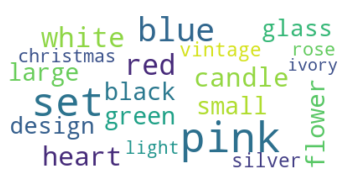

In [11]:
text=[t.lower() for t in descriptions]
#text=text.cat(sep=' ')
#text=text.lower()
text=' '.join([word for word in text])
#text=' '.join([word for word in text.split()])
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=ENGLISH_STOP_WORDS).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Based on the word cloud, we create our stopwords list.

In [12]:
custom_stopwords=ENGLISH_STOP_WORDS.union(['small', 'big','large','light','black', 'red', 'blue', 'green', 'white', 'black', 'pink','glass','ivory', 'metal', 'silver','zinc','set','vintage','design'])

### Using TfidfVectorizer

Apply TfidfVectorizer on descriptions.

In [13]:
vectorizer = TfidfVectorizer(stop_words=custom_stopwords) #default stop_words={'english'}
X_tfidf = vectorizer.fit_transform(descriptions) 
print(X_tfidf.shape)

(5699, 2541)


Use elbow criterion for determining number of category clusters.

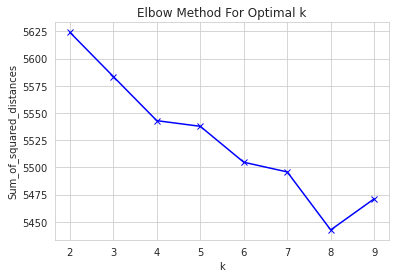

In [14]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000) #used insetead KMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000, n_jobs= -1) for speed improvement
    km = km.fit(X_tfidf)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Select number of clusters and create a wordcloud of each category cluster.

0    5026
3     275
1     204
2     194
Name: category, dtype: int64
Category: 0


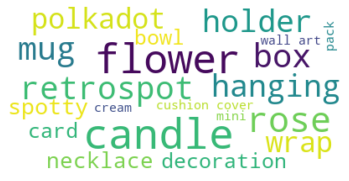

Category: 1


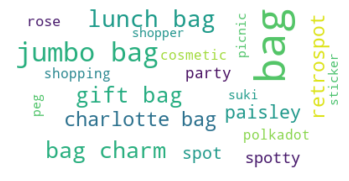

Category: 2


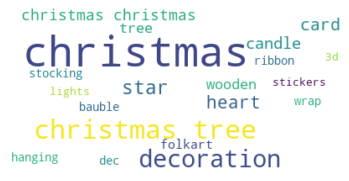

Category: 3


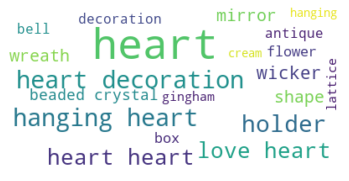

In [15]:
# set number of clusters
true_k = 4
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000) #KMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000)
model.fit(X_tfidf)
# get cluster assignment for each item set
labels=model.labels_
tfidf_description_category=pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])
# print number of items per cluster
print(tfidf_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=tfidf_description_category[tfidf_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Seems that:
* category 0 is a quite general,
* category 1 is about bags
* category 2 is about christmas decoration
* category 3 is about other type of decoration

### Using CountVectorizer

Apply CountVectorizer on descriptions.

In [16]:
vectorizer = CountVectorizer(stop_words=custom_stopwords) #default stop_words={'english'}
X_countvect = vectorizer.fit_transform(descriptions) 
print(X_countvect.shape)

(5699, 2541)


Use elbow criterion for determining number of category clusters.

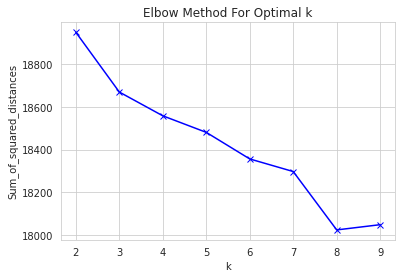

In [17]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000) #used insetead KMeans(n_clusters=k, max_iter=4000, n_init=500,  random_state=1000, n_jobs= -1) for speed improvement
    km = km.fit(X_countvect)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Select number of clusters and create a wordcloud of each category cluster.

2    5334
1     199
0     166
Name: category, dtype: int64
Category: 0


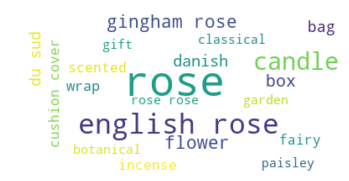

Category: 1


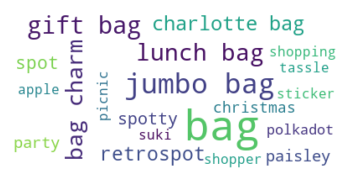

Category: 2


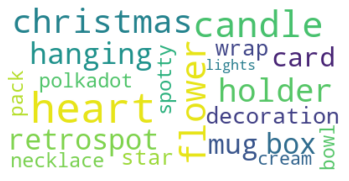

In [18]:
# set number of clusters
true_k = 3
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=100) #KMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500,  random_state=100)
model.fit(X_countvect)
# get cluster assignment for each item set
labels=model.labels_
countvec_description_category=pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])
# print number of items per cluster
print(countvec_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=countvec_description_category[countvec_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

It seems that four clusters with TfidfVectorizer are more clear. We are going to use this.

Please note one should **try** using both TfidfVectorizer and CountVectorizer for various number of clusters, complete customer clustering with all of them and then **decide** which to keep.

## Customer Segmentation

In this section we are going to add description categories to the data and use them for customer segmentation.

### Adding description categories

In [19]:
online_retail_categories= pd.merge(online_retail,tfidf_description_category,on='Description',how='inner')
online_retail_categories.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,category
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2
1,C489518,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:35:00,7.95,15461.0,United Kingdom,2
2,C489528,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:50:00,7.95,16714.0,United Kingdom,2
3,C489551,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 12:35:00,6.95,17641.0,United Kingdom,2
4,489559,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 12:55:00,6.95,17056.0,United Kingdom,2


After adding categories, for every row we calculate cost as the product of Quantity by Price.

In [20]:
online_retail_categories['cost']=online_retail_categories['Quantity']*online_retail_categories['Price']
online_retail_categories.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,category,cost
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2,83.40
1,C489518,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:35:00,7.95,15461.0,United Kingdom,2,-7.95
2,C489528,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:50:00,7.95,16714.0,United Kingdom,2,-7.95
3,C489551,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 12:35:00,6.95,17641.0,United Kingdom,2,-6.95
4,489559,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 12:55:00,6.95,17056.0,United Kingdom,2,83.40


With this data, we are able to calculate cost per category per month. Note that in category 2 there is a sharp increase on November while it is close to zero during the rest months. This verifies that category 2 has to do with Christmas related products. 

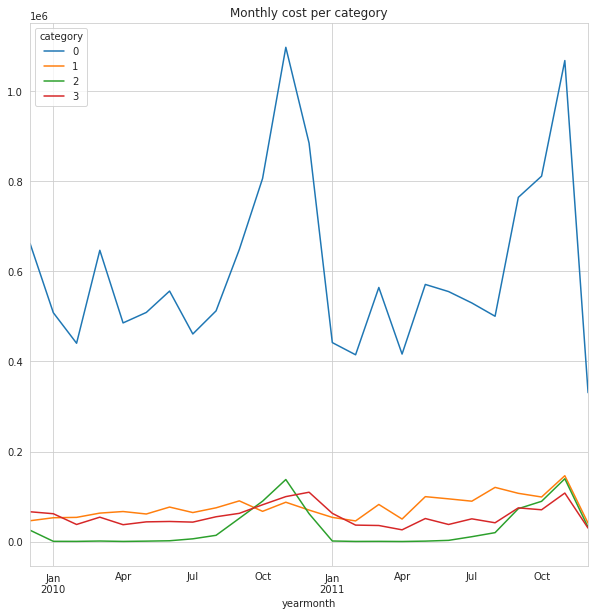

In [21]:
categories_per_date=online_retail_categories
categories_per_date['yearmonth']= online_retail_categories['InvoiceDate'].dt.to_period('M')
categories_per_date=categories_per_date.pivot_table(index=['yearmonth'], 
                    columns='category', 
                    values='cost',
                   # margins=True,  # add margins
                    aggfunc='sum').reset_index()
#categories_per_date.head()
lines=categories_per_date.plot.line(x="yearmonth", y=[0,1,2,3],figsize=(10,10),title='Monthly cost per category')
plt.show()

Next, we calculate total spending (cost) per category for every customer.

In [22]:
customer_spending_per_category=online_retail_categories.pivot_table(index=["Customer ID"], 
                    columns='category', 
                    values='cost',
                   # margins=True,  # add margins
                    aggfunc='sum').reset_index()
customer_spending_per_category.head()

category,Customer ID,0,1,2,3
0,12346.0,-79.66,NaN,14.98,NaN
1,12347.0,4810.70,570.6,23.48,228.54
2,12348.0,1838.20,NaN,94.20,87.00
3,12349.0,4073.79,37.2,10.20,283.35
4,12350.0,314.00,20.4,NaN,NaN


In [23]:
customer_spending_per_category=customer_spending_per_category.fillna(0)
customer_spending_per_category.head()

category,Customer ID,0,1,2,3
0,12346.0,-79.66,0.0,14.98,0.00
1,12347.0,4810.70,570.6,23.48,228.54
2,12348.0,1838.20,0.0,94.20,87.00
3,12349.0,4073.79,37.2,10.20,283.35
4,12350.0,314.00,20.4,0.00,0.00


In [24]:
customer_spending_per_category.describe()

category,Customer ID,0,1,2,3
count,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,2216.651141,267.612657,102.367331,215.168331
std,1715.451981,11269.495478,1924.722965,463.113440,1514.471148
min,12346.000000,-25111.090000,-72.000000,-832.200000,-404.500000
25%,13831.250000,255.870000,0.000000,0.000000,0.000000
50%,15316.500000,657.105000,16.500000,9.095000,35.850000
75%,16801.750000,1728.245000,90.000000,79.500000,144.105000
max,18287.000000,514594.400000,79054.080000,18117.660000,73979.340000


Finally, we will replace total cost per category with the percentage to the total cost across all categories. Notice, that in some cases, we have negative values. Probably this signifies returns. Since an item that is returned should have been bought in a previous time, we change negative values to positive. 

In [25]:
customer_spending_per_category['total']=abs(customer_spending_per_category[0])+abs(customer_spending_per_category[1])+abs(customer_spending_per_category[2])+abs(customer_spending_per_category[3])
# if total is 0 reset it to 1, otherwise NaNs will appear when dividing by total
customer_spending_per_category.loc[customer_spending_per_category['total']==0,'total']=1
customer_spending_per_category[0]=abs(customer_spending_per_category[0])/customer_spending_per_category['total']
customer_spending_per_category[1]=abs(customer_spending_per_category[1])/customer_spending_per_category['total']
customer_spending_per_category[2]=abs(customer_spending_per_category[2])/customer_spending_per_category['total']
customer_spending_per_category[3]=abs(customer_spending_per_category[3])/customer_spending_per_category['total']
customer_spending_per_category=customer_spending_per_category.drop(['total'],axis=1)
customer_spending_per_category.fillna(0)
customer_spending_per_category.head()

category,Customer ID,0,1,2,3
0,12346.0,0.841716,0.000000,0.158284,0.000000
1,12347.0,0.853972,0.101290,0.004168,0.040569
2,12348.0,0.910270,0.000000,0.046648,0.043082
3,12349.0,0.924907,0.008446,0.002316,0.064331
4,12350.0,0.938995,0.061005,0.000000,0.000000


### Customer clustering
This is the section with the actual customer clustering.

#### k-Means
We scale the input matrix and use the elbow method to decide the number of customer clusters.

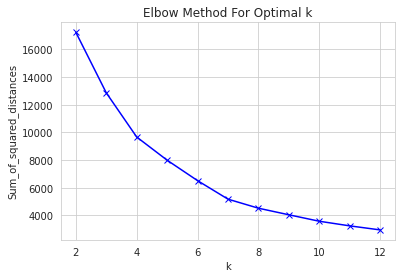

In [26]:
scaler = StandardScaler()
X_std = scaler.fit_transform(customer_spending_per_category.drop(['Customer ID'], axis=1))
Sum_of_squared_distances = []
K = range(2,13)
for k in K:
    km = KMeans(n_clusters=k, max_iter=5000, n_init=500, random_state=100,n_jobs= -1) 
    km = km.fit(X_std)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

##### Selecting 4 as the number of clusters.

In [27]:
# set number of clusters
true_k =4
# perform k-means clustering 
model = KMeans(n_clusters=true_k, max_iter=5000, n_init=500, random_state=100,n_jobs= -1) 
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster']=model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())
customer_spending_per_category['cluster']=model.labels_

1    4287
2     807
3     427
0     421
Name: cluster, dtype: int64


Function cluster_profile will be used to profile clusters.

        Customer ID         0         1         2         3
              count    median    median    median    median
cluster                                                    
0               421  0.670152  0.007819  0.228504  0.043079
1              4287  0.892189  0.015741  0.001038  0.031568
2               807  0.672202  0.005246  0.017402  0.246114
3               427  0.534162  0.362365  0.000000  0.009505




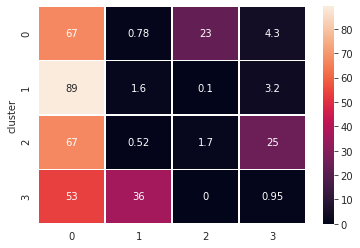

In [28]:
def cluster_profile(customer_spending_per_category):
  ''' profile clusters '''
  customer_clusters=customer_spending_per_category.groupby(['cluster']).agg({'Customer ID':['count'], 
                                                         0:'median',
                                                         1:'median',
                                                         2:'median',
                                                         3:'median'})
  print(customer_clusters)
  print('\n')
  customer_clusters=customer_clusters.drop([('Customer ID', 'count')],1)
  customer_clusters.columns=[0,1,2,3]
  
  customer_clusters[0]=100*customer_clusters[0]
  customer_clusters[1]=100*customer_clusters[1]
  customer_clusters[2]=100*customer_clusters[2]
  customer_clusters[3]=100*customer_clusters[3]
  

  sns.heatmap(customer_clusters, annot=True,  linewidths=.5)

cluster_profile(customer_spending_per_category)

We see that for all clusters there is a high percentage of spending in category 0. In addition:
* cluster 0 has customer with high spending in category 2,
* cluster 1 has high spending only in category 0,
* cluster 2 has customer with high spending in category 3,
* cluster 3 has customer with high spending in category 1.


In [29]:
customer_spending_per_category_k_Means=customer_spending_per_category.copy()

##### Selecting 6 as the number of clusters.

In [30]:
# set number of clusters
true_k = 6
# perform k-means clustering 
model = KMeans(n_clusters=true_k, max_iter=5000, n_init=500, random_state=100,n_jobs= -1) 
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster']=model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())

0    3801
1     691
4     655
5     626
2     121
3      48
Name: cluster, dtype: int64


        Customer ID         0         1         2         3
              count    median    median    median    median
cluster                                                    
0              3801  0.905833  0.010617  0.000000  0.030483
1               691  0.670277  0.002001  0.013151  0.267291
2               121  0.234431  0.758495  0.000000  0.000000
3                48  0.290878  0.000000  0.615904  0.000000
4               655  0.725639  0.016206  0.169938  0.057518
5               626  0.674432  0.241274  0.007932  0.032128




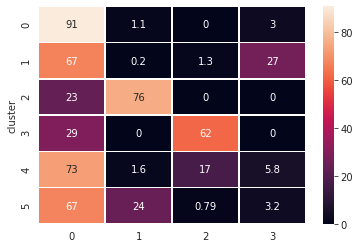

In [31]:
cluster_profile(customer_spending_per_category)

We see that we get clusters with higher percentage in category 1 or category 2 than category 0.

#### Hierachical clustering
Using hierachical clustering we can gain a better understanding of the possible number of clusters.

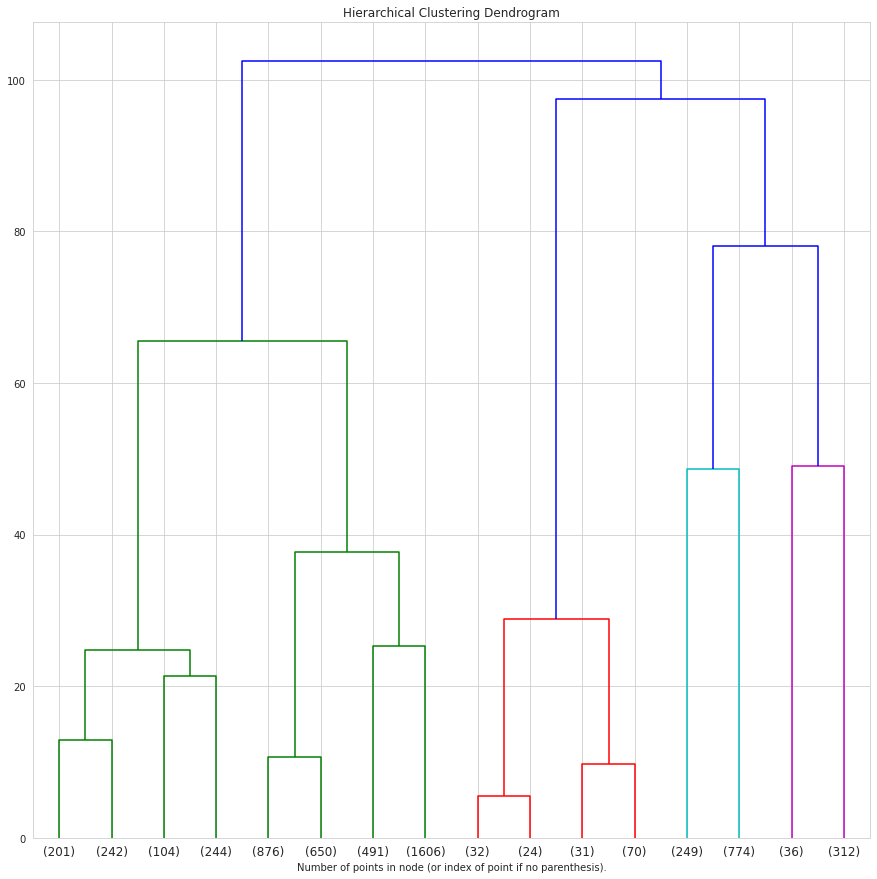

In [32]:
# source https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='ward')

model = model.fit(X_std)
plt.figure(figsize=(15,15))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

##### Selecting 4 as the number of clusters.

In [33]:
model = AgglomerativeClustering(n_clusters=4,linkage='ward')
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster']=model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())

0    4414
3    1023
1     348
2     157
Name: cluster, dtype: int64


        Customer ID         0         1         2         3
              count    median    median    median    median
cluster                                                    
0              4414  0.889064  0.021330  0.000708  0.029781
1               348  0.676525  0.007130  0.243169  0.022549
2               157  0.319656  0.643302  0.000000  0.000000
3              1023  0.697939  0.001869  0.024104  0.215819




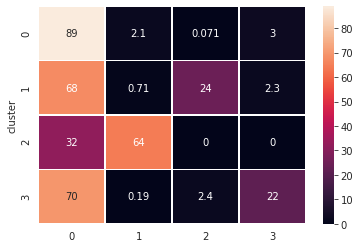

In [34]:
cluster_profile(customer_spending_per_category)

We observe that, now, the cluster with high spending in category 1 (cluster 3) has higher spending in category 1 than in category 0. This inversion is a result its smaller size. 

We will store the results of k-means clustering into 4 clusters.

In [35]:
customer_spending_per_category_k_Means.to_pickle('customer_segments_buying_categories.pickle')
# load with
# customer_spending_per_category = pd.read_pickle(file_name)

In [36]:
from google.colab import files
files.download('customer_segments_buying_categories.pickle') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>